In [54]:
import re
import os
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau

In [55]:
df=pd.read_csv("/Users/abhinavshinow/Documents/GitHub/Mal_URL/Data/XSS_dataset.csv")

In [57]:
seed_value= 0

os.environ['PYTHONHASHSEED']=str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

tf.random.set_seed(seed_value)

# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# tf.compat.v1.keras.backend.set_session(sess)

In [58]:
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [59]:
df.head()

,Sentence,Label
0,"<li><a href=""/wiki/File:Socrates.png"" class=""i...",0
1,"<tt onmouseover=""alert(1)"">test</tt>",1
2,"\t </span> <span class=""reference-text"">Steeri...",0
3,"\t </span> <span class=""reference-text""><cite ...",0
4,"\t </span>. <a href=""/wiki/Digital_object_iden...",0


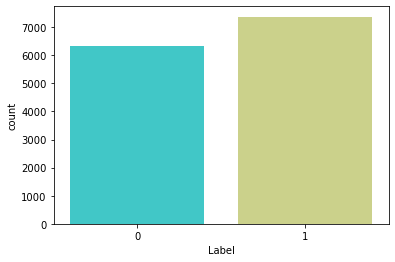

In [8]:
sns.countplot(x='Label',data=df, palette='rainbow')
plt.show()

In [60]:
SIZE = 100
BATCH_SIZE = 64
EPOCHS = 100

In [61]:
def convert_to_ascii(script):
    list = []
    for char in script:
        list.append(ord(char))
    vector = np.zeros((10000))
    for char in range(len(list)):
        vector[char] = list[char]
    vector.shape = (100,100)
    return vector

In [62]:
x = df["Sentence"].values
y = df["Label"]

In [63]:
arr=np.zeros((len(x),100,100))

for i in range(len(x)):
    image=convert_to_ascii(x[i]) 
    arr[i]=image

In [64]:
x = arr.reshape(arr.shape[0], 100, 100, 1)

In [65]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,shuffle='True',stratify=y)

In [66]:
model = Sequential()
model.add(Conv2D(64,(3,3), activation='relu', input_shape=(100,100,1)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [67]:
es = EarlyStopping(monitor='val_loss', 
        mode='min', 
        patience=5,
        restore_best_weights=True, 
        verbose=1)
mc = ModelCheckpoint('best_model.h5',verbose=1,save_best_only=True, save_weights_only = True)
reduce_lr=ReduceLROnPlateau( monitor="val_loss",factor=0.7,patience=5, verbose=1)
callbacks=[es,mc,reduce_lr]

In [68]:
model.compile(loss='binary_crossentropy',
                optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 98, 98, 64)        640       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 47, 47, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 21, 21, 256)       295168    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25600)            

In [69]:
history=model.fit(x_train,y_train,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_data=(x_test, y_test),callbacks=[es,mc,reduce_lr])

Epoch 1/100


2021-12-04 16:56:16.246689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


172/172 [==============================] - ETA: 0s - loss: 0.3177 - accuracy: 0.8850

2021-12-04 16:56:48.099760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


172/172 [==============================] - 35s 195ms/step - loss: 0.3177 - accuracy: 0.8850 - val_loss: 0.1460 - val_accuracy: 0.9551

Epoch 00001: val_loss improved from inf to 0.14603, saving model to best_model.h5
Epoch 2/100
172/172 [==============================] - 33s 193ms/step - loss: 0.0688 - accuracy: 0.9812 - val_loss: 0.0597 - val_accuracy: 0.9839

Epoch 00002: val_loss improved from 0.14603 to 0.05966, saving model to best_model.h5
Epoch 3/100
172/172 [==============================] - 33s 190ms/step - loss: 0.0532 - accuracy: 0.9866 - val_loss: 0.0968 - val_accuracy: 0.9690

Epoch 00003: val_loss did not improve from 0.05966
Epoch 4/100
172/172 [==============================] - 33s 189ms/step - loss: 0.0366 - accuracy: 0.9887 - val_loss: 0.0468 - val_accuracy: 0.9872

Epoch 00004: val_loss improved from 0.05966 to 0.04683, saving model to best_model.h5
Epoch 5/100
172/172 [==============================] - 35s 203ms/step - loss: 0.0315 - accuracy: 0.9906 - val_loss: 0.0

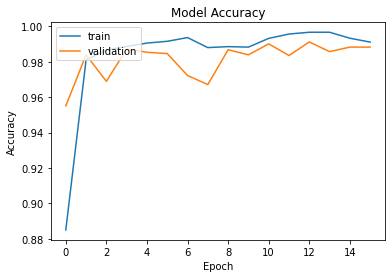

In [71]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [72]:
val_accuracy=max(history.history['val_accuracy'])
accuracy=max(history.history['accuracy'])
val_loss=min(history.history['val_loss'])
loss=min(history.history['loss'])
print(f'Test-Accuracy: {val_accuracy}')
print(f'Train-Accuracy: {accuracy}')
print(f'Test-loss: {val_loss}')
print(f'Train-loss: {loss}')

Test-Accuracy: 0.991234540939331
Train-Accuracy: 0.996711790561676
Test-loss: 0.0376046821475029
Train-loss: 0.008266792632639408


In [70]:
pred=model.predict(x_test)

2021-12-04 17:05:49.004193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
